In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import concurrent.futures
from tqdm import tqdm


In [2]:
# Paths to your data (update with actual paths)
benign_dir = r"E:\KARE\Capstone Project\Data\benign"
malignant_dir = r"E:\KARE\Capstone Project\Data\malignant"
ground_truth_path = r"E:\KARE\Capstone Project\Data\balanced_dataset.csv"  # Update this

# Load ground truth data
ground_truth_df = pd.read_csv(ground_truth_path)

In [3]:

# Preprocessing function remains the same
def load_dicom_image(file_path, input_shape=(224, 224)):
    try:
        dicom = pydicom.dcmread(file_path)
        img = dicom.pixel_array
        img = cv2.resize(img, input_shape)
        img = img / 255.0
        if len(img.shape) == 2:  # Grayscale to RGB
            img = np.stack((img,) * 3, axis=-1)
        return img
    except Exception as e:
        print(f"Failed to load image: {file_path} with error: {e}")
        return None

def load_data_and_labels_parallel(folder_path, label):
    images, labels = [], []
    file_paths = [os.path.join(folder_path, file_name) for file_name in os.listdir(folder_path) if file_name.endswith(".dcm")]

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(load_dicom_image, file_paths), total=len(file_paths)))

    for img in results:
        if img is not None:
            images.append(img)
            labels.append(label)

    print(f"Total loaded from {folder_path}: {len(images)} images with label '{label}'")
    return np.array(images), np.array(labels)

# Load data
benign_images, benign_labels = load_data_and_labels_parallel(benign_dir, "benign")
malignant_images, malignant_labels = load_data_and_labels_parallel(malignant_dir, "malignant")



100%|████████████████████████████████████████████████████████████████████████████████| 584/584 [25:16<00:00,  2.60s/it]


Total loaded from E:\KARE\Capstone Project\Data\benign: 584 images with label 'benign'


100%|████████████████████████████████████████████████████████████████████████████████| 584/584 [13:01<00:00,  1.34s/it]


Total loaded from E:\KARE\Capstone Project\Data\malignant: 584 images with label 'malignant'


In [10]:

# Assuming the CSV has a 'file_name' column for the image filenames and 'secondary_label' with values "Nevus" or "Unknown".
# Map filenames to their secondary labels for benign cases.
benign_secondary_labels = []
benign_file_names = [os.path.basename(file_path) for file_path in os.listdir(benign_dir)]
count =0 
# Map the secondary labels using the CSV file
for file_name in benign_file_names:
    record = ground_truth_df[ground_truth_df['image_name'] == file_name]
    if not record.empty:
        secondary_label = record.iloc[0]['daignosis']
        benign_secondary_labels.append(0 if secondary_label == "nevus" else 1)  # 0: Nevus, 1: Unknown
    else:
        count=count+1
        
print(count)

584


In [17]:
import os
import pandas as pd


# Assuming 'benign_dir' is defined as the directory containing the benign images
benign_secondary_labels = []
benign_file_names = [os.path.splitext(os.path.basename(file_path))[0] for file_path in os.listdir(benign_dir)]  # Extract base filenames
count = 0  # Initialize count

# Strip spaces from image names in the DataFrame
ground_truth_df['image_name'] = ground_truth_df['image_name'].str.strip()

# Map the secondary labels using the CSV file
for file_name in benign_file_names:
    # Compare the base filename (without extension) to the ground truth names
    record = ground_truth_df[ground_truth_df['image_name'] == file_name]

    if not record.empty:
        secondary_label = record.iloc[0]['diagnosis']  # Ensure correct spelling
        benign_secondary_labels.append(0 if secondary_label.lower() == "nevus" else 1)
        print("Suscess")
        count += 1# 0: Nevus, 1: Unknown
    else:
        print(f"Missing entry for: {file_name}")  # Debugging output
          # Increment count for missing entries

print(f"Count of files with no corresponding entry in ground truth: {count}")


Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess
Suscess


Benign filenames (without extensions): ['ISIC_0147817', 'ISIC_0177304', 'ISIC_0183290', 'ISIC_0185135', 'ISIC_0218747', 'ISIC_0226072', 'ISIC_0235728', 'ISIC_0260290', 'ISIC_0281291', 'ISIC_0355197', 'ISIC_0361034', 'ISIC_0418738', 'ISIC_0436964', 'ISIC_0440394', 'ISIC_0483289', 'ISIC_0492862', 'ISIC_0509700', 'ISIC_0511356', 'ISIC_0522926', 'ISIC_0527166', 'ISIC_0529262', 'ISIC_0531490', 'ISIC_0536321', 'ISIC_0563516', 'ISIC_0565046', 'ISIC_0576265', 'ISIC_0588103', 'ISIC_0595080', 'ISIC_0628277', 'ISIC_0648310', 'ISIC_0697951', 'ISIC_0705313', 'ISIC_0714807', 'ISIC_0745721', 'ISIC_0773096', 'ISIC_0781588', 'ISIC_0791303', 'ISIC_0800069', 'ISIC_0803691', 'ISIC_0808108', 'ISIC_0817091', 'ISIC_0851556', 'ISIC_0859438', 'ISIC_0862337', 'ISIC_0867357', 'ISIC_0900216', 'ISIC_0911989', 'ISIC_0922292', 'ISIC_0924302', 'ISIC_0938463', 'ISIC_0962601', 'ISIC_0965652', 'ISIC_0981883', 'ISIC_0982757', 'ISIC_1007608', 'ISIC_1014701', 'ISIC_1018102', 'ISIC_1052782', 'ISIC_1078563', 'ISIC_1130888', 

In [18]:

# Convert to numpy array for training
benign_secondary_labels = np.array(benign_secondary_labels)

# Combine and encode labels for primary classification
images = np.concatenate([benign_images, malignant_images], axis=0)
labels = np.concatenate([benign_labels, malignant_labels], axis=0)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)



In [19]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(images, encoded_labels, test_size=0.2, stratify=encoded_labels)



In [20]:
# Image data generator
datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.2, horizontal_flip=True)



In [21]:
# Model building functions remain the same
def build_resnet(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    output = Dense(2, activation='softmax')(x)  # Primary classification (malignant, benign)
    return Model(inputs=base_model.input, outputs=output)

def build_efficientnet(input_shape):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    output = Dense(2, activation='softmax')(x)  # Primary classification (malignant, benign)
    return Model(inputs=base_model.input, outputs=output)


In [22]:

# Build models
input_shape = (224, 224, 3)
resnet_model = build_resnet(input_shape)
efficientnet_model = build_efficientnet(input_shape)

# Compile models
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
efficientnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)



In [29]:
# Train models (use datagen for augmentation)
resnet_history = resnet_model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_val, y_val),
    epochs=20,callbacks=[early_stopping, reduce_lr]
)



Epoch 1/20
59/59 [==============================] - 381s 6s/step - loss: 0.6527 - accuracy: 0.6349 - val_loss: 0.7030 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
59/59 [==============================] - 354s 6s/step - loss: 0.6378 - accuracy: 0.6520 - val_loss: 0.7657 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
59/59 [==============================] - 374s 6s/step - loss: 0.6683 - accuracy: 0.5236 - val_loss: 0.7073 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
59/59 [==============================] - 325s 5s/step - loss: 0.5945 - accuracy: 0.6617 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 5/20
59/59 [==============================] - 342s 6s/step - loss: 0.5537 - accuracy: 0.7291 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 6/20
59/59 [==============================] - 346s 6s/step - loss: 0.5411 - accuracy: 0.7184 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 7/20
59/59 [==============================] - 351s 6s/step

In [47]:
resnet_accuracy = resnet_history.history['accuracy'][-1]
print(f"ResNet Accuracy: {resnet_history.history['accuracy'][-1]:.4f}")

ResNet Accuracy: 0.7259


In [33]:
efficientnet_history = efficientnet_model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_val, y_val),
    epochs=20,
   callbacks=[early_stopping, reduce_lr]
)



Epoch 1/20
59/59 [==============================] - 349s 6s/step - loss: 0.3239 - accuracy: 0.8630 - val_loss: 1.2607 - val_accuracy: 0.5299 - lr: 5.0000e-04
Epoch 2/20
59/59 [==============================] - 345s 6s/step - loss: 0.2589 - accuracy: 0.8951 - val_loss: 1.3078 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 3/20
59/59 [==============================] - 343s 6s/step - loss: 0.2499 - accuracy: 0.8919 - val_loss: 0.9175 - val_accuracy: 0.5897 - lr: 5.0000e-04
Epoch 4/20
59/59 [==============================] - 343s 6s/step - loss: 0.2096 - accuracy: 0.9143 - val_loss: 555.2059 - val_accuracy: 0.4701 - lr: 5.0000e-04
Epoch 5/20
59/59 [==============================] - 342s 6s/step - loss: 0.1977 - accuracy: 0.9218 - val_loss: 0.9867 - val_accuracy: 0.5556 - lr: 5.0000e-04
Epoch 6/20
59/59 [==============================] - 343s 6s/step - loss: 0.1457 - accuracy: 0.9433 - val_loss: 1.4123 - val_accuracy: 0.5342 - lr: 2.5000e-04


In [48]:
efficientNet_accuracy = efficientnet_history.history['accuracy'][-1] 
print(f"Efficient Accuracy: {efficientnet_history.history['accuracy'][-1]:.4f}")

Efficient Accuracy: 0.9433


In [37]:
# Train secondary classifier for "Benign" subclassification into "Nevus" or "Unknown"
def build_secondary_classifier(input_shape):
    model = tf.keras.Sequential([
        Flatten(input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')  # Nevus or Unknown
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



In [38]:
# Train secondary classifier
secondary_classifier = build_secondary_classifier((224, 224, 3))
X_train_benign, X_val_benign, y_train_benign, y_val_benign = train_test_split(
    benign_images, benign_secondary_labels, test_size=0.2, stratify=benign_secondary_labels)



In [41]:

secondary_history = secondary_classifier.fit(
    X_train_benign, y_train_benign,
    validation_data=(X_val_benign, y_val_benign),
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/20
15/15 [==============================] - 3s 185ms/step - loss: 0.4963 - accuracy: 0.9443 - val_loss: 0.5012 - val_accuracy: 0.9145 - lr: 2.5000e-04
Epoch 2/20
15/15 [==============================] - 2s 142ms/step - loss: 0.4790 - accuracy: 0.9422 - val_loss: 0.4727 - val_accuracy: 0.9060 - lr: 2.5000e-04
Epoch 3/20
15/15 [==============================] - 2s 149ms/step - loss: 0.6571 - accuracy: 0.8972 - val_loss: 1.1412 - val_accuracy: 0.8547 - lr: 2.5000e-04
Epoch 4/20
15/15 [==============================] - 2s 147ms/step - loss: 1.6280 - accuracy: 0.8223 - val_loss: 0.9837 - val_accuracy: 0.8803 - lr: 2.5000e-04
Epoch 5/20
15/15 [==============================] - 2s 148ms/step - loss: 0.6575 - accuracy: 0.9143 - val_loss: 0.4203 - val_accuracy: 0.9402 - lr: 1.2500e-04
Epoch 6/20
15/15 [==============================] - 2s 149ms/step - loss: 0.4436 - accuracy: 0.9422 - val_loss: 0.3458 - val_accuracy: 0.9487 - lr: 1.2500e-04
Epoch 7/20
15/15 [============================

In [49]:
secondaryModel_accuracy = secondary_history.history['accuracy'][-1]
print(f"Secondary Model Accuracy: {secondary_history.history['accuracy'][-1]:.4f}")

Secondary Model Accuracy: 0.9315


In [44]:
resnet_model.save(r"E:\KARE\Capstone Project\Models\resnet_model1.h5")
efficientnet_model.save(r"E:\KARE\Capstone Project\Models\efficientnet_model22.h5")
secondary_classifier.save(r"E:\KARE\Capstone Project\Models\secondary_model22.h5")

C:\Users\admin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
# Prediction function remains the same
def predict_image(model, secondary_model, file_path):
    img = load_dicom_image(file_path)
    img = np.expand_dims(img, axis=0)
    primary_prediction = model.predict(img)
    primary_label = np.argmax(primary_prediction, axis=1)[0]
    class_name = label_encoder.inverse_transform([primary_label])[0]

    if class_name == "benign":
        # Perform secondary classification
        print("Benign")
        secondary_prediction = secondary_model.predict(img)
        secondary_label = np.argmax(secondary_prediction, axis=1)[0]
        class_name = "Nevus" if secondary_label == 0 else "Unknown"

    return class_name

# Load the saved models for testing
resnet_model = load_model(r"E:\KARE\Capstone Project\Models\efficientnet_model22.h5")
secondary_classifier = load_model(r"E:\KARE\Capstone Project\Models\secondary_model22.h5")

# Test on a new DICOM file
test_file_path = r"E:\KARE\Capstone Project\Dataset\train\ISIC_0076995.dcm"
result = predict_image(resnet_model, secondary_classifier, test_file_path)
print(f"Diagnosis result: {result}")


1/1 [==============================] - 2s 2s/step
Benign
1/1 [==============================] - 0s 54ms/step
Diagnosis result: Nevus


                  Model   Accuracy
0          ResNet Model  72.591007
1    EfficientNet Model  94.325483
2  Secondary Classifier  93.147749


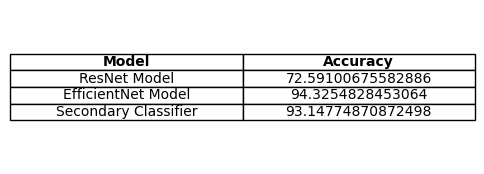

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
# Sample accuracies
model_names = ['ResNet Model', 'EfficientNet Model', 'Secondary Classifier']
accuracies = [(resnet_accuracy*100), (efficientNet_accuracy*100), (secondaryModel_accuracy*100)]

# Create a DataFrame
accuracy_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies
})

# Display the DataFrame
print(accuracy_df)
# Plot the DataFrame as a table
fig, ax = plt.subplots(figsize=(6,2))  # Set the size of the figure
ax.axis('tight')
ax.axis('off')

# Create the table
table_data = ax.table(cellText=accuracy_df.values,
                      colLabels=accuracy_df.columns,
                      cellLoc='center',
                      loc='center')

# Make the headings bold
for (i, j), cell in table_data.get_celld().items():
    if i == 0:  # If it's a header row
        cell.set_text_props(fontweight='bold')

# Save the table as an image
plt.savefig('model_accuracies.png', bbox_inches='tight', dpi=300)
plt.show()
